In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## load data

path = '/gpfs/commons/groups/knowles_lab/data/ADSP_reguloML/ADSP_vcf/phenotype_file/release_36K/'

ADNI = pd.read_csv(path + "ADNIPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
family_based = pd.read_csv(path + "ADSPFamilyBasedPhenotypes_DS_2022.08.18_ALL.txt", sep='\t',encoding='cp1252')
case_control = pd.read_csv(path + "ADSPCaseControlPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
PSPCBD = pd.read_csv(path + "PSPCBDPhenotypes_DS_2022.08.18_ALL.txt", sep='\t')
SUBJ_drop = pd.read_excel(path + 'ng00067_subject_droplist_2022.08.18.xlsx', engine = 'openpyxl')
PSPCBD_descript = pd.read_excel(path + 'PSPCBDPhenotypes_DD_2022.08.18.xlsx', engine = 'openpyxl')
vcf = pd.read_csv(path + 'vcf_ids.txt', sep = '\t')

/gpfs/commons/home/tlin/.conda/envs/polyfun/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
## SUBJID and SampleID are not 1-1 match

print(len(manifest.SUBJID.unique()))
print(len(manifest.SampleID.unique()))

51992
56863


In [4]:
print(ADNI.shape, family_based.shape, case_control.shape, PSPCBD.shape)

(1566, 31) (12858, 27) (45375, 31) (2803, 17)


In [43]:
print(ADNI.columns)
print(family_based.columns)
print(case_control.columns)
print(PSPCBD.columns)

Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age_current', 'Age_baseline',
       'Age_MCI_onset', 'Age_AD_onset', 'APOE_reported', 'APOE_WGS', 'AUTOPSY',
       'Braak', 'Race', 'Ethnicity', 'AD_last_visit', 'MCI_last_visit',
       'Duplicate_SUBJID', 'Comments', 'Latest_Update_Version', 'Base_PrevAD',
       'Base_IncAD', 'Base_Age', 'Base_AUTOPSY', 'Base_Braak', 'Base_AD',
       'Base_MCI', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_Diagnosis', 'Correction'],
      dtype='object')
Index(['SUBJID', 'FamID', 'Father', 'Mother', 'Sex', 'AD', 'Age',
       'Age_baseline', 'APOE_reported', 'APOE_WGS', 'AUTOPSY', 'Braak', 'Race',
       'Ethnicity', 'FamGrp', 'Comments', 'Duplicate_SUBJID',
       'Latest_Update_Version', 'Base_AD', 'Base_Age', 'Base_AUTOPSY',
       'Base_Braak', 'Base_Version', 'Update_baseline', 'Update_latest',
       'Update_ADstatus', 'Correction'],
      dtype='object')
Index(['SUBJID', 'Sex', 'PrevAD', 'IncAD', 'Age', 'Age_baseline',
     

In [5]:
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'Age_current', 'Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit']]

In [6]:
## There are two cases without age of onset

print(ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_AD_onset.isnull().sum())
print(ADNI_processed[ADNI_processed.AD_last_visit == 1][ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_AD_onset.isnull()])
print(ADNI_processed[ADNI_processed.AD_last_visit == 1].Age_baseline.isnull().sum())

## all controls have current age and the age they first entered the study!
ADNI_processed[ADNI_processed.AD_last_visit == 0].Age_current.isnull().sum()
ADNI_processed[ADNI_processed.AD_last_visit == 0].Age_baseline.isnull().sum()

2
              SUBJID  Sex Age_current Age_AD_onset Age_baseline  \
871  G-ADNI-AN000064    0          66          NaN           61   
975  G-ADNI-AN000170    0          76          NaN           73   

     APOE_reported  Race  AD_last_visit  
871             33   5.0              1  
975             34   5.0              1  
0


0

In [4]:
## ADNI
ADNI_processed = ADNI.loc[:,['SUBJID', 'Sex', 'Age_current', 'Age_AD_onset', 'Age_baseline','APOE_reported','Race', 'AD_last_visit']]
## fill the age of controls
ADNI_processed['Age_AD_onset'] = ADNI_processed['Age_AD_onset'].fillna(ADNI_processed['Age_current'])
ADNI_processed.rename(columns = {'Age_AD_onset':'Age', 'AD_last_visit':'Diagnosis'}, inplace = True)
ADNI_processed = ADNI_processed.drop(columns=['Age_current']).dropna()

In [5]:
## family_based

family_based['Diagnosis'] = 'NaN'
control = family_based[(family_based['AD'] == 0)| (family_based['AD'] == 10)].copy()
case = family_based[(family_based['AD'] >=1) & (family_based['AD'] <=4)].copy()

control.loc[:,["Diagnosis"]] = 0
case.loc[:,["Diagnosis"]] = 1
family_based = pd.concat([control,case])
family_based_processed = family_based.loc[:, ["SUBJID", "Sex", "Diagnosis", "APOE_reported","Age","Race", "Age_baseline"]]
print(family_based_processed.shape)

(6624, 7)


In [6]:
family_based_processed.isna().sum()


SUBJID              0
Sex                 0
Diagnosis           0
APOE_reported    2520
Age              2011
Race             1262
Age_baseline     2821
dtype: int64

In [7]:
family_based_processed = family_based_processed.dropna(subset = ['Age', 'APOE_reported', 'Race'])

In [8]:
## case_control
case_control_processed = case_control.loc[:,["SUBJID", "Sex", "AD", "APOE_reported","Age","Race", "Age_baseline"]]
case_control_processed = case_control_processed.rename(columns = {'AD':'Diagnosis'})

print(case_control_processed.isna().sum())
case_control_processed = case_control_processed.dropna(subset = ['Diagnosis','Age', 'APOE_reported', 'Race'])

SUBJID               0
Sex                  1
Diagnosis         5235
APOE_reported     5776
Age               4833
Race              2728
Age_baseline     18367
dtype: int64


In [9]:
print(case_control_processed.shape, case_control.shape)

(32644, 7) (45375, 31)


In [11]:
ADNI_processed["source"] = 'ADNI'
family_based_processed["source"] = 'Family_based'
case_control_processed["source"] = 'case_control'

In [12]:
pheno = pd.concat([ADNI_processed, family_based_processed, case_control_processed])

In [13]:
pheno.loc[pheno['Age'] == '90+', 'Age'] = 90
pheno.Age = pheno.Age.astype('int')

In [14]:
pheno

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1.0,87,76,33.0,5.0,0.0,ADNI
1,ADNI_002_S_0685,1.0,90,89,33.0,5.0,0.0,ADNI
2,ADNI_002_S_0729,1.0,68,65,34.0,5.0,1.0,ADNI
3,ADNI_002_S_1155,0.0,69,57,33.0,5.0,0.0,ADNI
4,ADNI_002_S_1261,1.0,82,71,33.0,5.0,0.0,ADNI
...,...,...,...,...,...,...,...,...
42341,G-KGAD-KA001265,1.0,56,76,34.0,5.0,1.0,case_control
42342,G-KGAD-KA001266,0.0,70,72,34.0,5.0,1.0,case_control
42343,G-KGAD-KA001267,0.0,60,62,34.0,5.0,1.0,case_control
42344,G-KGAD-KA001268,0.0,70,77,34.0,5.0,1.0,case_control


In [15]:
pheno.isna().sum()

SUBJID               0
Sex                  0
Age                  0
Age_baseline     14633
APOE_reported        0
Race                 0
Diagnosis            0
source               0
dtype: int64

In [16]:
duplicated_ID = pheno[pheno.SUBJID.duplicated()].SUBJID
pheno.shape

(112, 8)

In [17]:
duplicated_ID ## the duplicate ones 

16132    A-CUHS-CU000018
16133    A-CUHS-CU000169
16134    A-CUHS-CU000194
16135    A-CUHS-CU000387
16136    A-CUHS-CU000563
              ...       
31381     A-RAS-RA000012
31383     A-RAS-RA000016
31386     A-RAS-RA000020
31388     A-RAS-RA000022
33405     A-VAN-VU000119
Name: SUBJID, Length: 112, dtype: object

In [18]:
pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID')

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
2552,A-CUHS-CU000018,1.0,76,79,34.0,6.0,1.0,Family_based
16132,A-CUHS-CU000018,1.0,76,79,34.0,6.0,1.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control
2683,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,Family_based
2704,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,Family_based
...,...,...,...,...,...,...,...,...
12239,A-RAS-RA000020,0.0,71,NaN,34.0,5.0,1.0,Family_based
12243,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,Family_based
31388,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,case_control
11583,A-VAN-VU000119,0.0,71,NaN,34.0,5.0,1.0,Family_based


In [219]:
## The duplicates are between family based and case control, two as a pair
print(min(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))
print(max(pheno[pheno.SUBJID.isin(duplicated_ID)].value_counts('SUBJID')))

2
2


In [19]:
duplicates = pheno[pheno.SUBJID.isin(duplicated_ID)].sort_values('SUBJID', ascending = False)
not_identitcal_duplicates = duplicates.drop_duplicates(subset = ['SUBJID','Sex', 'Age', 'Age_baseline', 'APOE_reported'],keep = False)   

In [51]:
not_identitcal_duplicates.shape

(64, 8)

Text(0, 0.5, 'count')

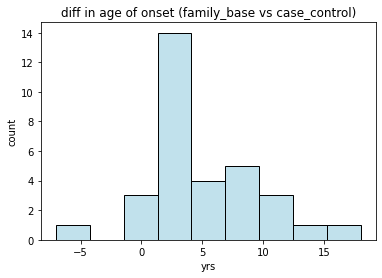

In [21]:
ax = sns.histplot(not_identitcal_duplicates.sort_values('source', ascending = False).groupby('SUBJID')['Age'].diff(), color = 'lightblue')
plt.title('diff in age of onset (family_base vs case_control)')
plt.xlabel('yrs')
plt.ylabel('count')
#

In [104]:
## except for age of onset, all the other columns are the same

not_identitcal_duplicates.groupby("SUBJID").Diagnosis.mean()

SUBJID
A-LOAD-LD000600    1.0
A-LOAD-LD000909    1.0
A-LOAD-LD001254    1.0
A-LOAD-LD001837    1.0
A-LOAD-LD002391    1.0
A-LOAD-LD002680    1.0
A-LOAD-LD002888    1.0
A-LOAD-LD003169    1.0
A-LOAD-LD003529    1.0
A-LOAD-LD003545    1.0
A-LOAD-LD003745    1.0
A-LOAD-LD004108    1.0
A-LOAD-LD004308    1.0
A-LOAD-LD004469    1.0
A-LOAD-LD004488    1.0
A-LOAD-LD004827    1.0
A-LOAD-LD005185    1.0
A-LOAD-LD005225    1.0
A-LOAD-LD005331    1.0
A-LOAD-LD007435    1.0
A-LOAD-LD007980    1.0
A-LOAD-LD010801    1.0
A-LOAD-LD010944    1.0
A-LOAD-LD011473    1.0
A-LOAD-LD011540    1.0
A-LOAD-LD011716    1.0
A-RAS-RA000001     1.0
A-RAS-RA000005     1.0
A-RAS-RA000009     1.0
A-RAS-RA000011     1.0
A-RAS-RA000012     1.0
A-RAS-RA000016     1.0
Name: Diagnosis, dtype: float64

In [22]:
not_identitcal_duplicates[not_identitcal_duplicates.SUBJID == 'A-LOAD-LD007980']

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
20654,A-LOAD-LD007980,0.0,65,58,34.0,5.0,1.0,case_control
8024,A-LOAD-LD007980,0.0,58,58,34.0,5.0,1.0,Family_based


In [23]:
not_identitcal_duplicates = not_identitcal_duplicates[(not_identitcal_duplicates['source'] == 'case_control') & (not_identitcal_duplicates.SUBJID != 'A-LOAD-LD007980')] ## 31 rows

In [130]:
duplicates[(~duplicates.SUBJID.isin(not_identitcal_duplicates.SUBJID)) & (duplicates.source == 'case_control')]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
33405,A-VAN-VU000119,0.0,71,NaN,34.0,5.0,1.0,case_control
31388,A-RAS-RA000022,0.0,75,NaN,34.0,5.0,1.0,case_control
31386,A-RAS-RA000020,0.0,71,NaN,34.0,5.0,1.0,case_control
28806,A-NCRD-NC017018,1.0,73,NaN,34.0,5.0,1.0,case_control
28734,A-NCRD-NC007634,0.0,71,NaN,34.0,5.0,1.0,case_control
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0.0,74,77,34.0,6.0,1.0,case_control
16135,A-CUHS-CU000387,1.0,87,71,23.0,6.0,0.0,case_control
16134,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control


In [45]:
identical_duplicates = duplicates[(~duplicates.SUBJID.isin(not_identitcal_duplicates.SUBJID)) & (duplicates.source == 'case_control') & (duplicates.SUBJID != 'A-LOAD-LD007980') ]

In [46]:
pheno_merge = pd.concat([pheno[(pheno.SUBJID != 'A-LOAD-LD007980') & (~pheno.SUBJID.isin(duplicated_ID))], not_identitcal_duplicates, identical_duplicates])

In [47]:
pheno_merge

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1.0,87,76,33.0,5.0,0.0,ADNI
1,ADNI_002_S_0685,1.0,90,89,33.0,5.0,0.0,ADNI
2,ADNI_002_S_0729,1.0,68,65,34.0,5.0,1.0,ADNI
3,ADNI_002_S_1155,0.0,69,57,33.0,5.0,0.0,ADNI
4,ADNI_002_S_1261,1.0,82,71,33.0,5.0,0.0,ADNI
...,...,...,...,...,...,...,...,...
16136,A-CUHS-CU000563,0.0,74,77,34.0,6.0,1.0,case_control
16135,A-CUHS-CU000387,1.0,87,71,23.0,6.0,0.0,case_control
16134,A-CUHS-CU000194,1.0,73,65,33.0,6.0,0.0,case_control
16133,A-CUHS-CU000169,1.0,87,84,33.0,5.0,0.0,case_control


In [170]:
print(len(pheno_merge.SUBJID.unique()))
print(pheno_merge.isna().sum())

38163
SUBJID               0
Sex                  0
Age                  0
Age_baseline     14603
APOE_reported        0
Race                 0
Diagnosis            0
source               0
dtype: int64


In [171]:
pheno_merge[pheno_merge.Age_baseline.isnull()]
pheno_merge.Age_baseline = pheno_merge.Age_baseline.fillna(pheno_merge.Age)
pheno_merge.loc[:, ['Sex', 'Age_baseline', 'APOE_reported', 'Race', 'Diagnosis']] = pheno_merge.loc[:, ['Sex', 'Age_baseline', 'APOE_reported', 'Race', 'Diagnosis']].astype(int)

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
1398,A-MIA-UM000061,1.0,87,NaN,23.0,5.0,0.0,Family_based
1399,A-MIA-UM000063,0.0,71,NaN,33.0,5.0,0.0,Family_based
1405,A-MIA-UM000341,1.0,74,NaN,34.0,5.0,0.0,Family_based
1410,A-MIA-UM000383,0.0,47,NaN,33.0,5.0,0.0,Family_based
1411,A-MIA-UM000387,1.0,63,NaN,33.0,5.0,0.0,Family_based
...,...,...,...,...,...,...,...,...
24684,A-MIA-UM000679,1.0,83,NaN,34.0,5.0,1.0,case_control
24683,A-MIA-UM000666,0.0,59,NaN,34.0,5.0,1.0,case_control
24671,A-MIA-UM000336,1.0,72,NaN,34.0,5.0,1.0,case_control
24670,A-MIA-UM000329,0.0,73,NaN,34.0,5.0,1.0,case_control


In [177]:
pheno_merge.to_csv(path + 'phenotype_merged.tsv',sep = '\t', index = False)

In [179]:
pheno[pheno.SUBJID.isin(SUBJ_drop)]


,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source


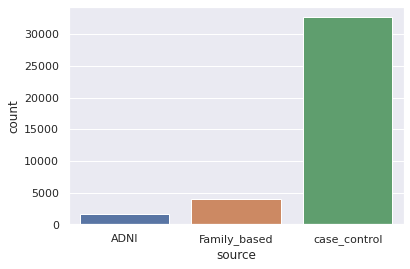

In [193]:
ax = sns.countplot(x="source", data=pheno_merge)

<AxesSubplot:title={'center':'data surce for pheno_merge'}>

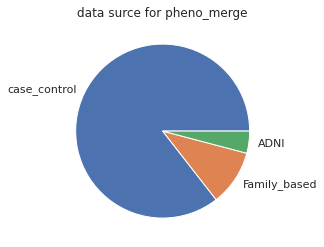

In [215]:
pheno_merge.source.value_counts().plot(kind='pie', ylabel='', title='data surce for pheno_merge')


### check PSPCBD

In [30]:
PSPCBD_descript

,VARNAME,VARDESC,COMMENTS,VALUES,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,SUBJID,GCAD Subject ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sex,Sex,NaN,0=Male,1=Female,NaN,NaN,NaN,NaN,NaN
2,Diagnosis,Status of Diagnosis,NaN,0=PSP Control,1=PSP,2-CBD,NaN,NaN,NaN,NaN
3,AgeOnset,Age at Onset,Age values of 90 or more are censored and code...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AgeDeath,Age at Death,Age values of 90 or more are censored and code...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Race,NIH Racial Categories,NaN,1=American Indian/Alaska Native,2=Asian,3=Native Hawaiian or Other Pacific Islander,4=Black or African American,5=White,6=Other,NaN
6,APOE_WGS,APOE genotype derived from WGS pVCF,NaN,22,23,24,33,34,44,NA = No WGS genotype call available
7,Duplicate_SUBJID,Subject was identified to be genetically ident...,NaN,0 = No alternate SUBJID,1 = Alternate SUBJID exists,NC = Not Available/Not Checked,NaN,NaN,NaN,NaN
8,Comments,"Notes about diagnosis coversions, updates, cor...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Latest_Update_Version,Release version of subject's most recent update,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
PSPCBD_descript = pd.read_excel(path + 'PSPCBDPhenotypes_DD_2022.08.18.xlsx', engine = 'openpyxl')

In [38]:
PSPCBD['Diagnosis'].value_counts()

1    2340
2     335
0     128
Name: Diagnosis, dtype: int64

In [40]:
#PSPCBD.loc[PSPCBD['Diagnosis'] == 2, 'Diagnosis'] = 1
print(PSPCBD.Diagnosis.value_counts())

1    2675
0     128
Name: Diagnosis, dtype: int64


In [43]:
PSPCBD[PSPCBD.SUBJID.isin(pheno.SUBJID)]

,SUBJID,Sex,Diagnosis,AgeOnset,AgeDeath,Race,APOE_WGS,Duplicate_SUBJID,Comments,Latest_Update_Version,Base_Diagnosis,Base_Version,Update_Baseline,Update_Latest,Update_Diagnosis,Correction,Consent


In [44]:
pheno[pheno.SUBJID.isin(PSPCBD.SUBJID)]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source


In [66]:
## Merge PSPCBD with pheno
#PSPCBD["source"] = "PSPCBD"
#PSPCBD = PSPCBD.rename(columns={"AgeOnset":"Age", "APOE_WGS":"APOE_reported"})
PSPCBD = PSPCBD.loc[:,['SUBJID','Sex','Diagnosis', 'Age','APOE_reported','Race','source']]

In [73]:
pheno_merge_new = pheno_merge.append(PSPCBD)

In [76]:
pheno_merge_new.Age_baseline = pheno_merge_new.Age_baseline.fillna(pheno_merge_new.Age)

In [77]:
pheno_merge_new

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
0,ADNI_002_S_0413,1,87,76,33.0,5.0,0,ADNI
1,ADNI_002_S_0685,1,90,89,33.0,5.0,0,ADNI
2,ADNI_002_S_0729,1,68,65,34.0,5.0,1,ADNI
3,ADNI_002_S_1155,0,69,57,33.0,5.0,0,ADNI
4,ADNI_002_S_1261,1,82,71,33.0,5.0,0,ADNI
...,...,...,...,...,...,...,...,...
2798,P-WZB-PSP10181,0,74,74,33.0,5.0,1,PSPCBD
2799,P-WZB-PSP10182,0,79,79,33.0,5.0,1,PSPCBD
2800,P-WZB-PSP5049,0,63,63,33.0,5.0,1,PSPCBD
2801,P-WZB-PSP5050,0,56,56,34.0,5.0,1,PSPCBD


case_control    32643
Family_based     3955
PSPCBD           2803
ADNI             1565
Name: source, dtype: int64


<AxesSubplot:title={'center':'data surce for pheno_merge'}>

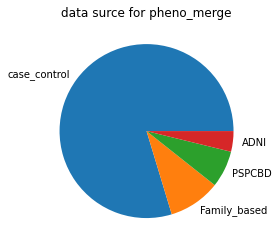

In [78]:
print(pheno_merge_new.source.value_counts())
pheno_merge_new.source.value_counts().plot(kind='pie', ylabel='', title='data surce for pheno_merge')


In [79]:
## Use the pheno with PSPCBD added
pheno_merge = pheno_merge_new

## add sample id

In [50]:
manifest = pd.read_csv(path + "SampleManifest_DS_2022.08.18_ALL.txt", sep='\t') ## the one with mapping info
#pheno_merge = pd.read_csv(path + 'phenotype_merged.tsv', sep = '\t')
manifest

,SUBJID,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
0,A-ACT-AC000004,A-ACT-AC000004-BL-UPN-15872,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
1,A-ACT-AC000007,A-ACT-AC000007-BL-UPN-6888,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
2,A-ACT-AC000008,A-ACT-AC000008-BL-UPN-8307,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
3,A-ACT-AC000010,A-ACT-AC000010-BL-UWA-15286,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
4,A-ACT-AC000014,A-ACT-AC000014-BL-UPN-23967,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
...,...,...,...,...,...,...,...,...,...,...
56858,A-LOAD-LD004371,A-LOAD-LD004371-BL-NCR-04AD7188u2-H07,Blood,DNA,USUHS,Illumina_HiSeqX,WGS,1,sa000001,snd10031
56859,A-LOAD-LD004371,A-LOAD-LD004371-BL-NCR-04AD7188u3-H07,Blood,DNA,USUHS,Illumina_NovaSeq,WGS,1,sa000001,snd10031
56860,A-NCRD-NC005389,A-NCRD-NC005389-BR-NCR-91M0544u1-B01,Brain,DNA,USUHS,Illumina_HiSeqX,WGS,1,sa000001,snd10031
56861,A-NCRD-NC005389,A-NCRD-NC005389-BR-NCR-91M0544u2-H08,Brain,DNA,USUHS,Illumina_HiSeqX,WGS,1,sa000001,snd10031


In [53]:
manifest[manifest.SUBJID.isin(pheno_merge.SUBJID)].Sequencing_Center.value_counts()

USUHS                15592
Broad                 5496
WashU                 4839
CU_IGM                3763
Baylor                3595
UM_HIHG               2817
Illumina              1150
NYGC                   976
MGI                    930
USUHS/Miami            720
Otogenetics            653
UW_GenomeSciences       57
GENENTECH               51
MEDGENOME                4
Name: Sequencing_Center, dtype: int64

In [139]:
manifest.groupby(['Sequencing_Center','SAMPLE_USE'])['SUBJID'].count()

Sequencing_Center  SAMPLE_USE
Baylor             WES            2346
                   WGS            1249
Broad              WES            4215
                   WGS            1281
CU_IGM             WES            3763
GENENTECH          WGS              51
Illumina           WGS            1150
MEDGENOME          WGS               4
MGI                WES             930
NYGC               WGS             976
Otogenetics        WES             653
UM_HIHG            WES            2817
USUHS              WGS           15592
USUHS/Miami        WGS             720
UW_GenomeSciences  WES              57
WashU              WES            3611
                   WGS            1228
Name: SUBJID, dtype: int64

In [128]:
## the only two rows in manifest file that got removed because appearing in SUBJ_drop
print(manifest[(manifest.SUBJID.isin(pheno_merge.SUBJID)) & (manifest.SUBJID.isin(SUBJ_drop.SUBJID))])

manifest = manifest[(manifest.SUBJID.isin(pheno_merge.SUBJID)) & (~manifest.SUBJID.isin(SUBJ_drop.SUBJID))]

print(manifest.shape)
#SUBJ_one2multi = manifest[manifest.SUBJID.isin(pheno_merge.SUBJID)][manifest[manifest.SUBJID.isin(pheno_merge.SUBJID)].SUBJID.duplicated(keep=False)]

               SUBJID                         SampleID BODY_SITE ANALYTE_TYPE  \
12879  A-MIA-UM000315  A-MIA-UM000315-UNK-MIA-19961724   Unknown          DNA   
12954  A-MIA-UM001976  A-MIA-UM001976-UNK-MIA-20010205   Unknown          DNA   

      Sequencing_Center       Sequencing_Platform SAMPLE_USE  \
12879           UM_HIHG  Illumina_HiSeq_2000/2500        WES   
12954           UM_HIHG  Illumina_HiSeq_2000/2500        WES   

       Technical_Replicate Study_DSS Sample_Set  
12879                    0  sa000006   snd10006  
12954                    0  sa000006   snd10006  
(40644, 10)


In [47]:
print(pheno_merge[pheno_merge.SUBJID == 'A-MIA-UM000315' ],
pheno_merge[pheno_merge.SUBJID == 'A-MIA-UM001976' ])

              SUBJID  Sex  Age  Age_baseline  APOE_reported  Race  Diagnosis  \
5261  A-MIA-UM000315    1   78            78             34     5          1   

            source  
5261  Family_based                 SUBJID  Sex  Age  Age_baseline  APOE_reported  Race  Diagnosis  \
5289  A-MIA-UM001976    1   78            78             33     5          1   

            source  
5289  Family_based  


In [156]:
## extract the WGS one if theres one
manifest_multi_WGS = manifest[(manifest.SUBJID.duplicated(keep=False)) & (manifest.SAMPLE_USE == 'WGS')].sort_values("SUBJID")
manifest_multi_WGS

,SUBJID,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
21390,A-ACT-AC000014,A-ACT-AC000014-BL-NCR-15AD78694,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
21391,A-ACT-AC000034,A-ACT-AC000034-BL-NCR-16AD84906,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
23048,A-ACT-AC000057,A-ACT-AC000057-BL-NCR-15AD78356,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
23049,A-ACT-AC000072,A-ACT-AC000072-BL-NCR-15AD77250,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
23050,A-ACT-AC000088,A-ACT-AC000088-BL-NCR-15AD76548,Blood,DNA,Broad,Illumina_HiSeqX,WGS,0,sa000001,snd10001
...,...,...,...,...,...,...,...,...,...,...
51109,G-KGAD-KA000754,G-KGAD-KA000754-UNK-WU-8038741273,Unknown,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
51353,G-KGAD-KA001030,G-KGAD-KA001030-BL-WU-8038741633,Blood,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
51487,G-KGAD-KA001030,G-KGAD-KA001030-UNK-WU-8038741581,Unknown,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
51183,G-KGAD-KA001216,G-KGAD-KA000886-BL-WU-8038741275,Blood,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032


In [157]:
manifest_multi_WGS[manifest_multi_WGS.duplicated(subset = 'SUBJID', keep = False)].value_counts('SUBJID')

SUBJID
A-CUHS-CU001163    13
A-CUHS-CU001166    13
A-CUHS-CU001167    12
A-CUHS-CU009833    10
A-NCRD-NC005389    10
                   ..
A-ADC-AD016053      2
A-ADC-AD016051      2
A-ADC-AD016049      2
A-ADC-AD016046      2
A-ADC-AD000017      2
Length: 599, dtype: int64

In [155]:
## print out the two SUBJID that has 13 sample IDs 

In [87]:
pheno_merge[pheno_merge.SUBJID == 'A-CUHS-CU001166']

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
3922,A-CUHS-CU001166,1,63,67,34,6,1,Family_based


In [88]:
pheno_merge[pheno_merge.SUBJID == 'A-CUHS-CU001163']

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
3921,A-CUHS-CU001163,1,89,85,23,6,1,Family_based


In [261]:
manifest[manifeset.SUBJID == 'A-CUHS-CU001166']

,SUBJID,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
20778,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1,Blood,DNA,Baylor,Illumina_HiSeq_2000,WGS,1,sa000001,snd10000
20779,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1r,Blood,DNA,Broad,Illumina_HiSeq_2000,WGS,1,sa000001,snd10000
20780,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1w,Blood,DNA,WashU,Illumina_HiSeq_2000,WGS,1,sa000001,snd10000
21337,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1dea,Blood,DNA,Baylor,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21338,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1der,Blood,DNA,Broad,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21339,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1dew,Blood,DNA,WashU,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21340,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1fa,Blood,DNA,Baylor,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21341,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1fr,Blood,DNA,Broad,Illumina_HiSeqX,WGS,1,sa000001,snd10001
21342,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1fw,Blood,DNA,WashU,Illumina_HiSeqX,WGS,1,sa000001,snd10001
44254,A-CUHS-CU001166,A-CUHS-CU001166-BL-COL-32166BL1ld,Blood,DNA,MEDGENOME,Illumina_HiSeqX,WGS,0,sa000019,snd10033


In [158]:
manifest_multi_WGS = manifest_multi_WGS.drop_duplicates(subset= 'SUBJID')

In [159]:
## WES
manifest_multi_WES = manifest[(manifest.SUBJID.duplicated(keep=False)) & (~manifest.SUBJID.isin(manifest_multi_sample.SUBJID))]
manifest_multi_WES

,SUBJID,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
1149,A-ACT-AC002970,A-ACT-AC002970-BL-NCR-11AD38111,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,1,sa000001,snd10000
1150,A-ACT-AC002970,A-ACT-AC002970-BL-NCR-11AD38111a,Blood,DNA,Baylor,Illumina_HiSeq_2000,WES,1,sa000001,snd10000
1151,A-ACT-AC002970,A-ACT-AC002970-BL-NCR-11AD38111r,Blood,DNA,Broad,Illumina_HiSeq_2000,WES,1,sa000001,snd10000
1152,A-ACT-AC002972,A-ACT-AC002972-BL-NCR-11AD38113,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,1,sa000001,snd10000
1153,A-ACT-AC002972,A-ACT-AC002972-BL-NCR-11AD38113a,Blood,DNA,Baylor,Illumina_HiSeq_2000,WES,1,sa000001,snd10000
...,...,...,...,...,...,...,...,...,...,...
14917,A-WCAP-WC000654,A-WCAP-WC000654-BL-COL-70589BL1,Blood,DNA,CU_IGM,Illumina_HiSeq_2000,WES,0,sa000007,snd10007
14923,A-WCAP-WC000660,A-WCAP-WC000660-BL-COL-35438BL1cwe,Blood,DNA,CU_IGM,Illumina_HiSeq_2000,WES,0,sa000007,snd10007
14926,A-WCAP-WC000663,A-WCAP-WC000663-BL-COL-50916BL1cwe,Blood,DNA,CU_IGM,Illumina_HiSeq_2000,WES,0,sa000007,snd10007
14928,A-WCAP-WC000665,A-WCAP-WC000665-BL-COL-35810BL1cwe,Blood,DNA,CU_IGM,Illumina_HiSeq_2000,WES,0,sa000007,snd10007


In [160]:
manifest_multi_WES = manifest_multi_WES.drop_duplicates(subset= 'SUBJID')
print(manifest_multi_WES.shape)

(183, 10)


In [163]:
manifest_merge = pd.concat([manifest[(~manifest.SUBJID.isin(manifest_multi_WES.SUBJID)) & (~manifest.SUBJID.isin(manifest_multi_WGS.SUBJID))], manifest_multi_WES, manifest_multi_WGS])

In [164]:
manifest_merge.shape

(36246, 10)

In [165]:
len(manifest_merge.SUBJID.unique())

36246

In [167]:
manifest_merge

,SUBJID,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
0,A-ACT-AC000004,A-ACT-AC000004-BL-UPN-15872,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
1,A-ACT-AC000007,A-ACT-AC000007-BL-UPN-6888,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
2,A-ACT-AC000008,A-ACT-AC000008-BL-UPN-8307,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
3,A-ACT-AC000010,A-ACT-AC000010-BL-UWA-15286,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
5,A-ACT-AC000015,A-ACT-AC000015-BL-UPN-39345,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
...,...,...,...,...,...,...,...,...,...,...
51276,G-KGAD-KA000738,G-KGAD-KA000738-UNK-WU-8038741215,Unknown,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
51078,G-KGAD-KA000746,G-KGAD-KA000746-UNK-WU-8038741188,Unknown,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
51109,G-KGAD-KA000754,G-KGAD-KA000754-UNK-WU-8038741273,Unknown,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032
51353,G-KGAD-KA001030,G-KGAD-KA001030-BL-WU-8038741633,Blood,DNA,USUHS,Illumina_NovaSeq,WGS,0,sa000023,snd10032


In [169]:
pheno_merge.shape

(38163, 8)

In [171]:
pheno_w_sampleID = pheno_merge.merge(manifest_merge)

In [172]:
pheno_w_sampleID

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source,SampleID,BODY_SITE,ANALYTE_TYPE,Sequencing_Center,Sequencing_Platform,SAMPLE_USE,Technical_Replicate,Study_DSS,Sample_Set
0,ADNI_002_S_0413,1,87,76,33,5,0,ADNI,ADNI_002_S_0413,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
1,ADNI_002_S_0685,1,90,89,33,5,0,ADNI,ADNI_002_S_0685,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
2,ADNI_002_S_0729,1,68,65,34,5,1,ADNI,ADNI_002_S_0729,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
3,ADNI_002_S_1155,0,69,57,33,5,0,ADNI,ADNI_002_S_1155,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
4,ADNI_002_S_1261,1,82,71,33,5,0,ADNI,ADNI_002_S_1261,Blood,DNA,Illumina,Illumina_HiSeq_2000,WGS,0,sa000002,snd10002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36241,A-CUHS-CU000563,0,74,77,34,6,1,case_control,A-CUHS-CU000563-BL-COL-47451BL1,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
36242,A-CUHS-CU000387,1,87,71,23,6,0,case_control,A-CUHS-CU000387-BL-COL-38200BL2,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
36243,A-CUHS-CU000194,1,73,65,33,6,0,case_control,A-CUHS-CU000194-BL-COL-38470BL1,Blood,DNA,WashU,Illumina_HiSeq_2000,WES,0,sa000001,snd10000
36244,A-CUHS-CU000169,1,87,84,33,5,0,case_control,A-CUHS-CU000169-BL-COL-57413BL1dew,Blood,DNA,WashU,Illumina_HiSeqX,WGS,0,sa000001,snd10001


In [175]:
pheno_w_sampleID.SAMPLE_USE.value_counts()

WGS    21590
WES    14656
Name: SAMPLE_USE, dtype: int64

In [174]:
pheno_w_sampleID.to_csv(path+'pheno_merge_sampleID.tsv', sep = '\t', index = False)

In [176]:
38163-36246

1917

In [177]:
pheno_merge[~pheno_merge.SUBJID.isin(manifest_merge.SUBJID)]

,SUBJID,Sex,Age,Age_baseline,APOE_reported,Race,Diagnosis,source
1575,A-CUHS-CU000386,0,74,74,33,6,0,Family_based
1576,A-CUHS-CU000388,0,81,81,23,6,0,Family_based
1577,A-CUHS-CU000389,0,76,76,33,6,0,Family_based
1578,A-CUHS-CU000390,0,64,57,33,6,0,Family_based
1580,A-CUHS-CU000401,1,59,59,33,6,0,Family_based
...,...,...,...,...,...,...,...,...
5502,A-LOAD-LD014144,1,61,61,44,5,1,Family_based
5503,A-LOAD-LD010144,1,74,80,34,5,1,Family_based
5517,A-CUHS-CU007232,0,73,77,34,5,1,Family_based
5518,A-CUHS-CU007253,1,65,69,44,4,1,Family_based
